# Lab 5 - Dynamical Models: Perelson et al.

In this implementation we're going to implement a [dynamical model](http://science.sciencemag.org/content/271/5255/1582), and evaluate it's properties. The pdf version of Perelson et al. can be found [here](https://www.ms.uky.edu/~ma137/Fasttrack13/HIV_Perelson_Science1996.pdf).

### (0) Import necessary packages

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, the fitted parameters and the appropriate constants were used to generate the curves shown on these plots.

The table below summarizes the different variables presented in both the paper and the code.

| Variable in Paper| Variable in Code| Definition                                         |
|:---------------- |:--------------- |:-------------------------------------------------- |
| $k$              | $k$             | rate constant                                      |
| $t$              | $t$             | time                                               |
| $T$              | $T\_base$       | target cells                                       |
| $T^{*}$          | $Tstar$         | productively infected cells                        |
| $V$              | $Vt$            | concentration of viral particles in plasma         |
| $\delta$         | $delta$         | rate of loss of virus-producing cells              |
| $N$              | $N$             | number of new virions produced per infected cell   |
| $c$              | $c$             | rate constant for virion clearance                 |
| $V_{I}$          | $V\_I$          | plasma concentration of virions in infectious pool |
| $V_{NI}$         | $V\_NI$         | concentration of virions in noninfectious pool     |

#### (i) Implement eq. 6 from the paper as a function.

In [2]:
def V_t(V_0, t, c, delta):
    '''Eq. 6 in Perelson et al. calculates total concentration of plasma virions'''
    exp_ct = np.exp(-c*t)
    exp_dt = np.exp(-delta*t)
    c_frac = float(c)/(c-delta)
    Vt = V_0*exp_ct + V_0*c_frac*(c_frac*(exp_dt - exp_ct) - delta*t*exp_ct)
    return Vt

#### (ii) Make the plot from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in [Wein et al. (J. Theor. Biol. 192:81-98)](https://core.ac.uk/download/pdf/4380299.pdf) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for $T^{*}$, $V_{I}$, and $V_{NI}$ to reproduce the data in Figure 1.

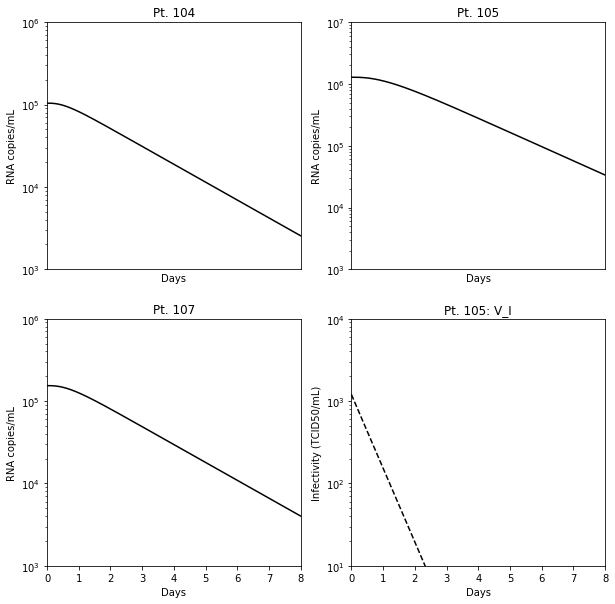

In [3]:
# rate constant from Wein et al.
k = 3.43e-8

# time vectors
t_104 = np.linspace(-2/24, 8, 10000); t_105 = np.linspace(-6/24, 8, 10000); t_107 = np.linspace(-2/24, 8, 10000)

# V, c, and delta data from Table 1
V0_104 = 2*52e3;  c_104 = 3.68; delta_104 = 0.50;
V0_105 = 2*643e3; c_105 = 2.06; delta_105 = 0.53;
V0_107 = 2*77e3;  c_107 = 3.09; delta_107 = 0.50;

# Calculate V(t)
Vt_104 = V_t(V0_104, t_104, c_104, delta_104)
Vt_105 = V_t(V0_105, t_105, c_105, delta_105)
Vt_107 = V_t(V0_107, t_107, c_107, delta_107)

plt.figure(figsize=(10, 10))

# Pt. 104
plt.subplot(221)
plt.semilogy(t_104, Vt_104, 'k')
plt.xlim(0,8)
plt.ylim(1e3, 1e6)
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.title('Pt. 104')
plt.xticks([])

# Pt. 107
plt.subplot(223)
plt.semilogy(t_107, Vt_107, 'k')
plt.xlim(0,8)
plt.ylim(1e3, 1e6)
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.title('Pt. 107')

# Pt. 105
plt.subplot(222)
plt.semilogy(t_105, Vt_105, 'k')
plt.xlim(0,8)
plt.ylim(1e3, 1e7)
plt.title('Pt. 105')
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.xticks([])

# Pt. 105 -- VI
VI_105 = 1.2e3*np.exp(-c_105*t_105)
plt.subplot(224)
plt.semilogy(t_105, VI_105, 'k--')
plt.xlim(0,8)
plt.ylim(1e1, 1e4)
plt.xlabel('Days')
plt.ylabel('Infectivity (TCID50/mL)')
plt.title('Pt. 105: V_I');

### (2) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [4]:
def diffEqs(vec, t, N, T_base, k, delta, c, eta):
    '''Eq. 4-6 of Perelson et al. calculate and return time derivatives of each species'''
    Tstar = vec[0]
    V_I = vec[1]
    V_NI = vec[2]
    dTstar_dt = k*V_I*(T_base-Tstar) - delta*Tstar
    dV_I_dt = -c*V_I + (1-eta)*(N*delta*Tstar)
    dV_NI_dt = eta*(N*delta*Tstar) - c*V_NI
    return dTstar_dt, dV_I_dt, dV_NI_dt

#### ii. Use odeint to solve this system of equations numerically for patient 105.

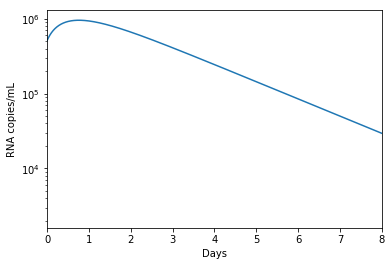

In [5]:
# This function solves the system of equations for a patient
def systemsolver(diffEqs, Tbase, V0, t, k, delta, c, eta):
    Tstar0 = k*V0*Tbase/(k*V0+delta)
    V_I0 = V0
    V_NI0 = 0
    N = c*V_I0/(delta*Tstar0)
    solution = odeint(diffEqs, [Tstar0, V_I0, V_NI0], t, args=(N, Tbase, k, delta, c, eta))
    return solution

# Initial parameters for Pt. 105
t_105 = np.linspace(-6/24, 8, 10000)
k = 3.43e-8
Tbase_105 = 11e3
eta = 1

# Solve system for Pt. 105
p105 = systemsolver(diffEqs, Tbase_105, V0_105, t_105, k, delta_105, c_105, eta)
plt.semilogy(t_105, p105[:,2])
plt.xlim([0,8])
plt.xlabel('Days')
plt.ylabel('RNA copies/mL');

#### iii. Reproduce the subpanels of Fig. 1 with this updated model.

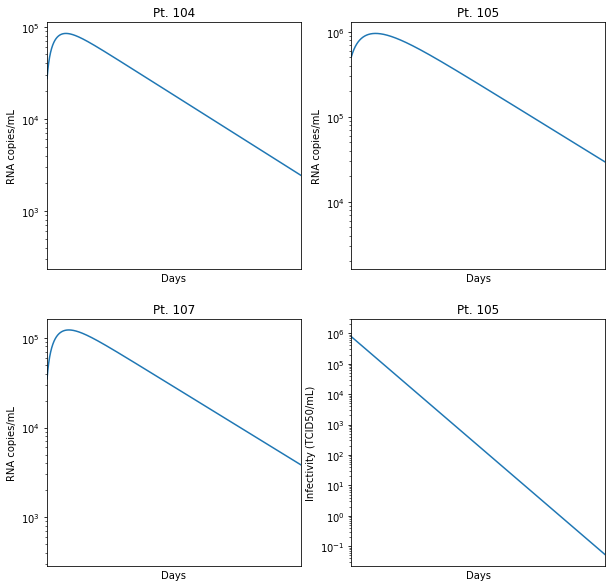

In [6]:
# Initial parameters
Tbase_104 = 2e3; Tbase_105 = 11e3; Tbase_107 = 412e3
t_104 = np.linspace(-2/24, 8, 10000); t_105 = np.linspace(-6/24, 8, 10000); t_107 = np.linspace(-2/24, 8, 10000)
k = 3.43e-8
eta = 1

# Solve for each patient
p104 = systemsolver(diffEqs, Tbase_104, V0_104, t_104, k, delta_104, c_104, eta)
p105 = systemsolver(diffEqs, Tbase_105, V0_105, t_105, k, delta_105, c_105, eta)
p107 = systemsolver(diffEqs, Tbase_107, V0_107, t_107, k, delta_107, c_107, eta)

plt.figure(figsize=(10,10))

# Pt. 104
plt.subplot(221)
plt.semilogy(t_104, p104[:,2])
plt.xlim([0,8])
plt.title('Pt. 104')
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.xticks([])

# Pt. 107
plt.subplot(223)
plt.semilogy(t_107, p107[:,2])
plt.xlim([0,8])
plt.title('Pt. 107')
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.xticks([])

# Pt. 105
plt.subplot(222)
plt.semilogy(t_105, p105[:,2])
plt.xlim([0,8])
plt.title('Pt. 105')
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.xticks([])

# Pt. 105 -- VI
plt.subplot(224)
plt.semilogy(t_105, p105[:,1])
plt.xlim([0,8])
plt.title('Pt. 105')
plt.xlabel('Days')
plt.ylabel('Infectivity (TCID50/mL)')
plt.xticks([]);

#### iv. Are the results the same as in (1)?

The results are similar to (1) but are not identical. The odeint model has a strong curve in the beginning. One possible explanation is the presence of a delay that was not correctly accounted for.

### (3) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 days-1 and δ=0.5 days-1 as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

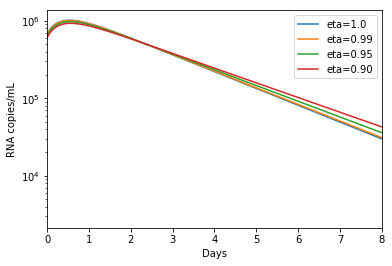

In [7]:
# Vary the effectiveness factor of the drug
etas = [1.0, 0.99, 0.95, 0.90]

# Store the simulation in this array
varyEffFactor = np.zeros((len(etas), len(t_105), 3))

# Solve system for every effectiveness factor, and plot
for eta in range(0, len(etas)):
    c = 3; delta = 0.5
    varyEffFactor[eta,:,:] = systemsolver(diffEqs, Tbase_105, V0_105, t_105, k, delta, c, etas[eta])
    plt.semilogy(t_105, varyEffFactor[eta,:,2])
    
plt.xlim([0,8])
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.legend(['eta=1.0','eta=0.99','eta=0.95','eta=0.90']);

#### (ii) Then, use the function scipy.optimize.leastsq to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss the consequences of an imperfect drug on clearance time estimates.

In [8]:
# Residuals function, calculates error
def residuals(x0, diffEqs, Tbase, V0, t, k, eta, real_delta, real_c):
    # x0 is [delta, c]
    eta1= systemsolver(diffEqs, Tbase, V0, t, k, real_delta, real_c, 1)[t>0][:,2]
    eta_new = systemsolver(diffEqs, Tbase, V0, t, k, x0[0], x0[1], eta)[t>0][:,2]
    return (eta_new - eta1)

# Given by Item 12 of “References and Notes" in Perelson et al. 
delta_arr = np.zeros(len(etas))
c_arr = np.zeros(len(etas))
actual_delta = [0.500, 0.494, 0.470, 0.441]
actual_c = [3.000, 3.003, 3.015, 3.028]

# Evaluate for each effectiveness factor
for eta in range(0, len(etas)):
    ls_sq = sp.optimize.least_squares(residuals, np.array([delta, c]), args=(diffEqs, Tbase_105, V0_105, t_105, k, etas[eta], delta, c))
    delta_arr[eta] = ls_sq.x[0]
    c_arr[eta] = ls_sq.x[1]
    print('eta = %f:' % etas[eta])
    print('lst sq delta = %f, lst sq c = %f' % (delta_arr[eta], c_arr[eta]))
    print('actual delta = %f, actual c = %f' % (actual_delta[eta], actual_c[eta]))
    print('--')


eta = 1.000000:
lst sq delta = 0.500000, lst sq c = 3.000000
actual delta = 0.500000, actual c = 3.000000
--
eta = 0.990000:
lst sq delta = 0.498544, lst sq c = 3.042059
actual delta = 0.494000, actual c = 3.003000
--
eta = 0.950000:
lst sq delta = 0.493656, lst sq c = 3.209222
actual delta = 0.470000, actual c = 3.015000
--
eta = 0.900000:
lst sq delta = 0.489009, lst sq c = 3.423377
actual delta = 0.441000, actual c = 3.028000
--


As the effectiveness factor of the drug decreases, the rate of loss of virus-producing cells decreases and the rate constant for virion clearance increases.

#### (iii) Examine the residual plots from your fits to determine whether or not there is a trend in the error associated with fitting these new curves.

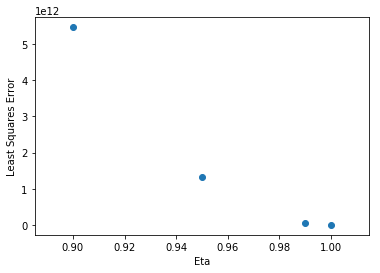

In [9]:
# Plot residuals
ls_sq_cost = np.zeros(len(etas))
for eta in range(0, len(etas)):
    ls_sq = sp.optimize.least_squares(residuals, np.array([delta, c]), args=(diffEqs, Tbase_105, V0_105, t_105, k, etas[eta], delta, c))
    ls_sq_cost[eta] = ls_sq.cost

plt.scatter(etas, ls_sq_cost)
plt.xlabel('Eta')
plt.ylabel('Least Squares Error');

The trend for error is that the error decreases as the effectiveness of the drug increases and becomes closer to 1.0.

### (4) To determine the TCID50 one should estimate an infectivity coefficient.

To calculate the infectivity coefficient, estimate the ratio of VI(t=0) to the value of TCID50(t=0) for patient 105 from Perelson’s Figure 1. This coefficient acts as a conversion factor between the number of virions in the infectious pool, VI, and the TCID50, and is an indicator of the efficiency of the HIV-1 transmission.

In [10]:
TCID50 = 1.1e3 #from Perelson's Figure 1
inf_coeff = p105[0,1]/TCID50
print('Infectivity Coefficient = %f' % inf_coeff)

Infectivity Coefficient = 1169.090909
